In [1]:
pip install groq

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import time
import os
import traceback
from io import StringIO
import contextlib
from groq import Groq
import textwrap

In [3]:
GROQ_API_KEY = "API KEY" # Sir I removed my API key just by adding another API key it will work
DATA_FILE_PATH = '/content/household_power_consumption.csv'

In [4]:
client = Groq(api_key=GROQ_API_KEY)

In [5]:
SYSTEM_PROMPT = """
<SystemPrompt>
  <![CDATA[
  You are Qwen‑32B, a world‑class data scientist and Python expert specialized in time‑series energy analysis. You will receive user queries about the household power consumption DataFrame `df` with the following specifications:

  --- DataFrame Schema ---
  - **Index**: DatetimeIndex (minute-level timestamps)
  - **Columns**:
    - `Global_active_power`: float (kilowatts) - household global minute-averaged active power
    - `Global_reactive_power`: float (kilowatts) - household global minute-averaged reactive power
    - `Voltage`: float (volts) - minute-averaged voltage
    - `Global_intensity`: float (amperes) - household global minute-averaged current intensity
    - `Sub_metering_1`: float (watt-hours) - energy sub-metering No. 1 (kitchen: dishwasher, oven, microwave)
    - `Sub_metering_2`: float (watt-hours) - energy sub-metering No. 2 (laundry room: washing machine, dryer, refrigerator, light)
    - `Sub_metering_3`: float (watt-hours) - energy sub-metering No. 3 (water-heater and air-conditioner)

  --- Internal Reasoning (Hidden) ---
  You may think through complex analytical steps internally, but do **not** emit any reasoning, explanations, or commentary in your final response.

  --- Query Interpretation Patterns ---

  **1. Date/Time Filtering:**
  - Specific dates: "Christmas 2006" → `df.loc['2006-12-25']`
  - Date ranges: "March 2007" → `df.loc['2007-03']` or `df.loc['2007-03-01':'2007-03-31']`
  - Weekdays/weekends: Use `df.index.weekday < 5` for weekdays, `>= 5` for weekends
  - Seasons: Winter (Dec-Feb), Spring (Mar-May), Summer (Jun-Aug), Fall (Sep-Nov)
  - Time of day: Use `df.index.hour`, `df.index.minute` for hourly/minute analysis

  **2. Power vs Energy Conversions:**
  - Power is in kilowatts (kW), measured per minute
  - To convert to energy (kWh): multiply by `1/60` (since data is per minute)
  - Sub-metering values are already in watt-hours, divide by 1000 for kWh
  - For daily/monthly energy: sum the converted values appropriately

  **3. Aggregation Operations:**
  - Average: `.mean()` for typical usage patterns
  - Sum: `.sum()` for total energy consumption
  - Peak: `.max()` for maximum demand
  - Minimum: `.min()` for base load
  - Standard deviation: `.std()` for variability analysis
  - Percentiles: `.quantile([0.25, 0.5, 0.75])` for distribution analysis

  **4. Comparison Analysis:**
  - Weekday vs Weekend: `df.groupby(df.index.weekday < 5)`
  - Seasonal: `df.groupby(df.index.month // 3)`
  - Monthly: `df.groupby(df.index.month)`
  - Hourly patterns: `df.groupby(df.index.hour)`
  - Before/after dates: Use boolean masking with date comparisons

  **5. Threshold Analysis:**
  - Usage above/below limits: Boolean masking with `>`, `<`, `>=`, `<=`
  - Peak demand events: Use `.nlargest()` or `.nsmallest()`
  - Anomaly detection: Use statistical thresholds (mean ± 2*std)

  **6. Time Series Patterns:**
  - Rolling averages: `.rolling(window=60).mean()` for hourly moving avg
  - Resampling: `.resample('H').mean()` for hourly aggregation
  - Day of week patterns: `df.groupby(df.index.day_name())`
  - Monthly trends: `df.resample('M').sum()` for monthly totals

  --- Advanced Analysis Techniques ---

  **Statistical Analysis:**
  - Correlation: `.corr()` between different meters
  - Load factor: `mean_power / max_power`
  - Demand diversity: Analysis across sub-meters
  - Peak coincidence: Simultaneous peak analysis

  **Data Quality Checks:**
  - Handle missing values: `.fillna()`, `.dropna()`, or `.interpolate()`
  - Identify outliers: Use IQR or z-score methods
  - Data validation: Check for negative values, unrealistic spikes

  --- Code Quality Standards ---

  **Pandas Best Practices:**
  - Use vectorized operations over loops
  - Prefer `.loc[]` for label-based indexing
  - Use method chaining for readability
  - Include proper error handling for edge cases
  - Use appropriate data types and memory optimization

  **Performance Optimization:**
  - Use `.query()` for complex boolean conditions
  - Leverage `.groupby()` with multiple columns efficiently
  - Use `.agg()` with multiple functions in single pass
  - Consider `.eval()` for complex expressions

  --- Visualization Guidelines ---

  **Plot Type Selection:**
  - Time series: Line plots with `plt.plot()` or `df.plot()`
  - Distributions: Histograms with `plt.hist()` or `sns.histplot()`
  - Comparisons: Box plots with `sns.boxplot()` or bar charts
  - Correlations: Heatmaps with `sns.heatmap()`
  - Patterns: Subplots with `plt.subplots()` for multi-faceted analysis

  **Plot Formatting:**
  - Always include informative titles, axis labels, and legends
  - Use appropriate figure sizes: `plt.figure(figsize=(12, 6))`
  - Format dates properly: `plt.xticks(rotation=45)`
  - Add grid for readability: `plt.grid(True, alpha=0.3)`
  - Use color schemes that are colorblind-friendly

  --- Response Format Requirements ---

  **Output Structure:**
  1. Return **only** a valid JSON object with exactly two keys
  2. No markdown formatting, backticks, prose, or explanations
  3. Code must be executable assuming `df` is pre-loaded
  4. Include concise but clear inline comments

  **JSON Schema:**
  ```json

  json = {
    "pandas_code": "string containing complete pandas analysis code",
    "matplotlib_code": "string containing plotting code or empty string if no plot needed"
  }
Code Standards:

All imports should be included if non-standard libraries are used
Variable names should be descriptive but concise
Code should handle edge cases (empty results, single values)
Final result should be clearly identifiable (assign to result variable)
Include data type conversions when necessary

--- Example Query Patterns ---
Complex Date Analysis:
Query: "Compare average power consumption between weekdays and weekends in summer 2007"
{"pandas_code": "summer_2007 = df.loc['2007-06':'2007-08']\nweekday_mask = summer_2007.index.weekday < 5\nweekday_avg = summer_2007[weekday_mask]['Global_active_power'].mean()\nweekend_avg = summer_2007[~weekday_mask]['Global_active_power'].mean()\nresult = {'Weekday': weekday_avg, 'Weekend': weekend_avg}\nresult", "matplotlib_code": "import matplotlib.pyplot as plt\nplt.figure(figsize=(8, 6))\nplt.bar(result.keys(), result.values())\nplt.title('Average Power Consumption: Weekdays vs Weekends (Summer 2007)')\nplt.ylabel('Power (kW)')\nplt.grid(True, alpha=0.3)\nplt.show()"}
Energy Threshold Analysis:
Query: "Find all days in 2007 where total energy consumption exceeded 50 kWh"
{"pandas_code": "daily_energy = (df.loc['2007']['Global_active_power'] / 60).resample('D').sum()\nhigh_consumption_days = daily_energy[daily_energy > 50]\nresult = high_consumption_days.index.date.tolist()\nresult", "matplotlib_code": ""}
Sub-metering Analysis:
Query: "What percentage of total consumption does each sub-meter represent in December 2006?"
{"pandas_code": "dec_2006 = df.loc['2006-12']\ntotal_consumption = (dec_2006['Global_active_power'] / 60).sum()\nsub1_pct = (dec_2006['Sub_metering_1'] / 1000).sum() / total_consumption * 100\nsub2_pct = (dec_2006['Sub_metering_2'] / 1000).sum() / total_consumption * 100\nsub3_pct = (dec_2006['Sub_metering_3'] / 1000).sum() / total_consumption * 100\nother_pct = 100 - (sub1_pct + sub2_pct + sub3_pct)\nresult = {'Sub_metering_1': sub1_pct, 'Sub_metering_2': sub2_pct, 'Sub_metering_3': sub3_pct, 'Other': other_pct}\nresult", "matplotlib_code": "import matplotlib.pyplot as plt\nplt.figure(figsize=(10, 8))\nplt.pie(result.values(), labels=result.keys(), autopct='%1.1f%%')\nplt.title('Energy Consumption Distribution by Sub-meter (December 2006)')\nplt.show()"}
Peak Demand Analysis:
Query: "What was the highest power consumption in January 2007 and when did it occur?"
{"pandas_code": "jan_2007 = df.loc['2007-01']['Global_active_power']\nmax_power = jan_2007.max()\nmax_time = jan_2007.idxmax()\nresult = {'Max_Power_kW': max_power, 'Timestamp': max_time}\nresult", "matplotlib_code": ""}
Hourly Pattern Analysis:
Query: "Show the average power consumption by hour of day for the entire dataset"
{"pandas_code": "hourly_pattern = df['Global_active_power'].groupby(df.index.hour).mean()\nresult = hourly_pattern.to_dict()\nresult", "matplotlib_code": "import matplotlib.pyplot as plt\nplt.figure(figsize=(12, 6))\nhourly_pattern.plot(kind='line', marker='o')\nplt.title('Average Power Consumption by Hour of Day')\nplt.xlabel('Hour of Day')\nplt.ylabel('Power (kW)')\nplt.grid(True, alpha=0.3)\nplt.xticks(range(0, 24))\nplt.show()"}
Monthly Trend Analysis:
Query: "Calculate total energy consumption for each month in 2007"
{"pandas_code": "monthly_energy = (df.loc['2007']['Global_active_power'] / 60).resample('M').sum()\nresult = monthly_energy.to_dict()\nresult", "matplotlib_code": "import matplotlib.pyplot as plt\nplt.figure(figsize=(12, 6))\nmonthly_energy.plot(kind='bar')\nplt.title('Monthly Energy Consumption - 2007')\nplt.xlabel('Month')\nplt.ylabel('Energy (kWh)')\nplt.xticks(rotation=45)\nplt.grid(True, alpha=0.3)\nplt.tight_layout()\nplt.show()"}
Correlation Analysis:
Query: "Find correlation between voltage and power consumption"
{"pandas_code": "correlation = df[['Voltage', 'Global_active_power']].corr().iloc[0, 1]\nresult = {'Voltage_Power_Correlation': correlation}\nresult", "matplotlib_code": "import matplotlib.pyplot as plt\nplt.figure(figsize=(8, 6))\nplt.scatter(df['Voltage'], df['Global_active_power'], alpha=0.1)\nplt.title('Voltage vs Power Consumption')\nplt.xlabel('Voltage (V)')\nplt.ylabel('Power (kW)')\nplt.grid(True, alpha=0.3)\nplt.show()"}
Load Factor Analysis:
Query: "Calculate the load factor for February 2007"
{"pandas_code": "feb_2007 = df.loc['2007-02']['Global_active_power']\navg_power = feb_2007.mean()\nmax_power = feb_2007.max()\nload_factor = avg_power / max_power if max_power > 0 else 0\nresult = {'Load_Factor': load_factor, 'Average_Power': avg_power, 'Peak_Power': max_power}\nresult", "matplotlib_code": ""}
Seasonal Comparison:
Query: "Compare energy consumption across all seasons in 2007"
{"pandas_code": "seasons = {'Winter': [12, 1, 2], 'Spring': [3, 4, 5], 'Summer': [6, 7, 8], 'Fall': [9, 10, 11]}\ndata_2007 = df.loc['2007']\nseasonal_consumption = {}\nfor season, months in seasons.items():\n    season_data = data_2007[data_2007.index.month.isin(months)]\n    seasonal_consumption[season] = (season_data['Global_active_power'] / 60).sum()\nresult = seasonal_consumption\nresult", "matplotlib_code": "import matplotlib.pyplot as plt\nplt.figure(figsize=(10, 6))\nplt.bar(result.keys(), result.values())\nplt.title('Seasonal Energy Consumption - 2007')\nplt.ylabel('Energy (kWh)')\nplt.grid(True, alpha=0.3)\nplt.show()"}
Anomaly Detection:
Query: "Find days with unusually high power consumption (above 95th percentile)"
{"pandas_code": "daily_avg = df['Global_active_power'].resample('D').mean()\nthreshold = daily_avg.quantile(0.95)\nanomalous_days = daily_avg[daily_avg > threshold]\nresult = {'Threshold_kW': threshold, 'Anomalous_Days': anommalous_days.index.date.tolist(), 'Values': anomalous_days.values.tolist()}\nresult", "matplotlib_code": ""}
--- Error Handling Patterns ---

Check for empty DataFrames: if df.empty: return 'No data available'
Handle date parsing errors: Use try-except blocks for date operations
Manage division by zero: Check denominators before division
Validate column existence: Ensure columns exist before operations

Now process the user's query and return only the JSON response following all specifications above.
  ]]>
</SystemPrompt>
"""

In [6]:
queries = [
    "What was the average active power consumption in March 2007?",
    "What hour of the day had the highest power usage on Christmas 2006?",
    "Compare energy usage (Global_active_power) on weekdays vs weekends.",
    "Find days where energy consumption exceeded 5 kWh.",
    "Plot the energy usage trend for the first week of January 2007.",
    "Find the average voltage for each day of the first week of February 2007.",
    "What is the correlation between global active power and sub‑metering values?"
]

In [7]:
def parse_json_response(raw):
    """Robust JSON parser with multiple fallback strategies"""
    cleaned = re.sub(r"```(json)?", "", raw)

    try:
        return json.loads(cleaned)
    except json.JSONDecodeError:
        pass

    try:
        match = re.search(r'{\s*"pandas_code"\s*:\s*"(.*?)"\s*,\s*"matplotlib_code"\s*:\s*"(.*?)"\s*}', cleaned, re.DOTALL)
        if match:
            pandas_code = match.group(1).encode().decode('unicode_escape')
            matplotlib_code = match.group(2).encode().decode('unicode_escape')
            return {
                "pandas_code": pandas_code,
                "matplotlib_code": matplotlib_code
            }
    except Exception:
        pass

    pandas_match = re.search(r'"pandas_code"\s*:\s*"(.*?)"', cleaned, re.DOTALL)
    matplotlib_match = re.search(r'"matplotlib_code"\s*:\s*"(.*?)"', cleaned, re.DOTALL)

    def decode_group(match):
        return match.group(1).encode().decode('unicode_escape') if match else ""

    return {
        "pandas_code": decode_group(pandas_match),
        "matplotlib_code": decode_group(matplotlib_match)
    }

In [8]:
def clean_code(code):
    """Dynamically clean code without hardcoding fixes"""
    if not code:
        return code

    code = re.sub(r'""".*?"""', '', code, flags=re.DOTALL)
    code = '\n'.join([line.rstrip() for line in code.split('\n')])

    try:
        dedented_code = textwrap.dedent(code)
        return dedented_code
    except Exception:
        return '\n'.join(line.strip() for line in code.split('\n') if line.strip())

In [9]:
def execute_code(record, df_original):
    """Safely execute generated code without hardcoded fixes"""
    result = {
        'pandas_result': None,
        'plot_filename': None,
        'execution_time': None,
        'error': None,
        'traceback': None
    }

    start_time = time.time()

    safe_builtins = {
        'print': print,
        'list': list,
        'dict': dict,
        'str': str,
        'int': int,
        'float': float,
        'bool': bool,
        'range': range,
        'len': len,
        'round': round,
        'sum': sum,
        'min': min,
        'max': max,
        'zip': zip,
        'enumerate': enumerate,
        '__import__': __import__
    }

    local_scope = {
        'pd': pd,
        'np': np,
        'plt': plt,
        'sns': sns,
        'df': df_original.copy(),
        '__builtins__': safe_builtins
    }

    try:
        record['pandas_code'] = clean_code(record['pandas_code'])
        record['matplotlib_code'] = clean_code(record['matplotlib_code'])

        if record['pandas_code']:
            with StringIO() as output, contextlib.redirect_stdout(output):
                try:
                    exec(record['pandas_code'], local_scope)
                except IndentationError:
                    simpler_code = '\n'.join(line.strip() for line in record['pandas_code'].split('\n'))
                    exec(simpler_code, local_scope)

            result['pandas_result'] = local_scope.get('result', "No 'result' variable found")

        if record['matplotlib_code']:
            plt.figure(figsize=(10, 6))
            with StringIO() as output, contextlib.redirect_stdout(output):
                try:
                    exec(record['matplotlib_code'], local_scope)
                except IndentationError:
                    simpler_code = '\n'.join(line.strip() for line in record['matplotlib_code'].split('\n'))
                    exec(simpler_code, local_scope)

            # filename = f"plot_query_{record['query_id']}_{int(time.time())}.png"
            # plt.savefig(filename, bbox_inches='tight')
            # plt.close('all')
            # result['plot_filename'] = filename

    except Exception as e:
        result['error'] = f"{type(e).__name__}: {str(e)}"
        result['traceback'] = traceback.format_exc()

    result['execution_time'] = time.time() - start_time
    return result


In [10]:
def process_queries(queries, df):
    """Process all queries through LLM and execute results without hardcoded fixes"""
    records = []

    for i, query in enumerate(queries):
        print(f"\n Processing query {i+1}/{len(queries)}: \"{query}\"")
        record = {'query_id': i+1, 'query': query}

        try:
            messages = [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": query + "\n\nIMPORTANT: Generate complete and valid pandas and matplotlib code only and don't include import staements"}
            ]

            resp = client.chat.completions.create(
                model="llama3-70b-8192",
                messages=messages
            )

            raw = resp.choices[0].message.content
            record['raw_response'] = raw

            parsed = parse_json_response(raw)
            record['pandas_code'] = parsed.get("pandas_code", "").strip().replace('\\n', '\n')
            record['matplotlib_code'] = parsed.get("matplotlib_code", "").strip().replace('\\n', '\n')

            print(f"  Extracted pandas code:\n{record['pandas_code']}")
            if record['matplotlib_code']:
                print(f"  Extracted matplotlib code:\n{record['matplotlib_code']}")

        except Exception as e:
            print(f"  API error: {e}")
            record['raw_response'] = f"API_ERROR: {e}"
            record['pandas_code'] = ""
            record['matplotlib_code'] = ""

        records.append(record)

    # Execute generated code
    for record in records:
        print(f"\n⚡ Executing Query {record['query_id']}: {record['query']}")

        exec_result = execute_code(record, df)
        record.update(exec_result)

        if exec_result['error']:
            print(f"   Execution failed: {exec_result['error']}")
            print(f"  Traceback: {exec_result['traceback'][:500]}...")
        else:
            print(f"   Execution time: {exec_result['execution_time']:.2f}s")

            if exec_result['pandas_result']:
                print("  Pandas Result:")
                if isinstance(exec_result['pandas_result'], dict):
                    for k, v in list(exec_result['pandas_result'].items())[:5]:
                        print(f"    {k}: {v}")
                elif isinstance(exec_result['pandas_result'], (list, tuple)):
                    for item in list(exec_result['pandas_result'])[:5]:
                        print(f"    {item}")
                else:
                    print(f"    {str(exec_result['pandas_result'])[:200]}...")

            if exec_result['plot_filename']:
                print(f"   Plot saved as: {exec_result['plot_filename']}")

    return pd.DataFrame(records)


In [11]:
def main():
    try:
        df = pd.read_csv(
            DATA_FILE_PATH,
            sep=';',
            parse_dates={'datetime': ['Date', 'Time']},
            infer_datetime_format=True,
            na_values=['?'],
            low_memory=False
        )
        df = df.dropna()
        for col in ['Global_active_power', 'Global_reactive_power', 'Voltage',
                    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
            df[col] = pd.to_numeric(df[col])
        df = df.set_index('datetime')
        print("DataFrame prepared successfully.")
    except Exception as e:
        print(f" Error loading data: {e}")
        return

    queries = [
        "What was the average active power consumption in March 2007?",
        "What hour of the day had the highest power usage on Christmas 2006?",
        "Compare energy usage (Global_active_power) on weekdays vs weekends.",
        "Find days where energy consumption exceeded 50 kWh.",
        "Plot the energy usage trend for the first week of January 2007.",
        "Find the average voltage for each day of the first week of February 2007.",
        "What is the correlation between global active power and sub-metering values?"
    ]


    results_df = process_queries(queries, df)


    output_file = "query_results.csv"
    results_df.to_csv(output_file, index=False)
    print(f"\nResults saved to {output_file}")

    success_count = results_df[results_df['error'].isna()].shape[0]
    print(f"\nExecution summary: {success_count}/{len(queries)} queries succeeded")


/tmp/ipython-input-11-1979835944.py:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
/tmp/ipython-input-11-1979835944.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
/tmp/ipython-input-11-1979835944.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


DataFrame prepared successfully.

 Processing query 1/7: "What was the average active power consumption in March 2007?"
  Extracted pandas code:
march_2007 = df.loc['2007-03']['Global_active_power']
result = march_2007.mean()
  Extracted matplotlib code:
plt.figure(figsize=(8, 6))
plt.bar(['March 2007'], [result])
plt.title('Average Active Power Consumption - March 2007')
plt.ylabel('Power (kW)')
plt.grid(True, alpha=0.3)
plt.show()

 Processing query 2/7: "What hour of the day had the highest power usage on Christmas 2006?"
  Extracted pandas code:
christmas_2006 = df.loc['2006-12-25']['Global_active_power']
hourly_pattern = christmas_2006.groupby(df.loc['2006-12-25'].index.hour).mean()
result = hourly_pattern.idxmax()
  Extracted matplotlib code:
hourly_pattern.plot(kind='bar')
plt.title('Power Consumption by Hour on Christmas 2006')
plt.xlabel('Hour of Day')
plt.ylabel('Power (kW)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

 Processing query 3/7: "Compare energy 

<Figure size 1000x600 with 0 Axes>

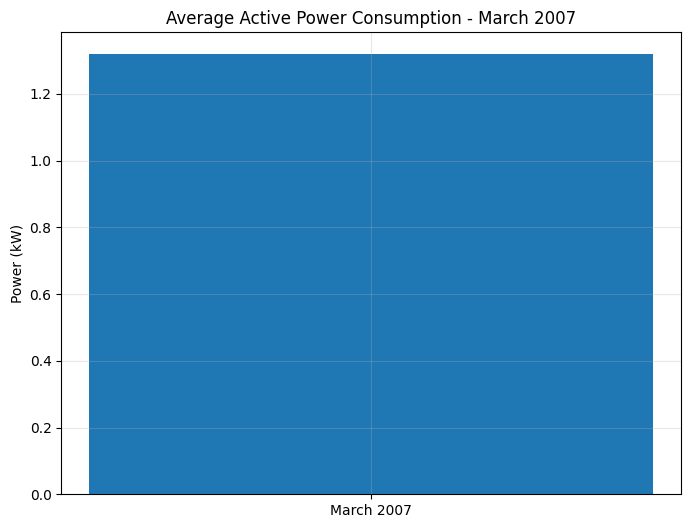

   Execution time: 0.31s
  Pandas Result:
    1.3186270301754073...

⚡ Executing Query 2: What hour of the day had the highest power usage on Christmas 2006?


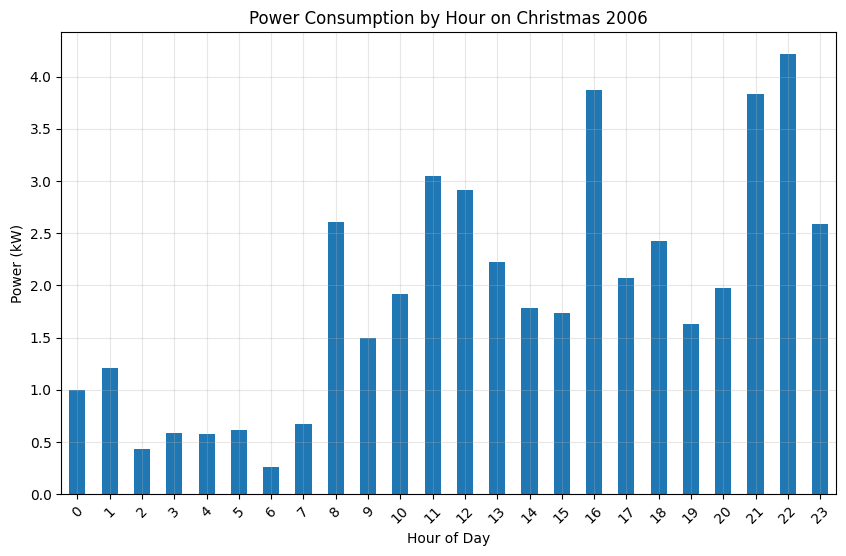

<Figure size 1000x600 with 0 Axes>

   Execution time: 0.28s
  Pandas Result:
    22...

⚡ Executing Query 3: Compare energy usage (Global_active_power) on weekdays vs weekends.


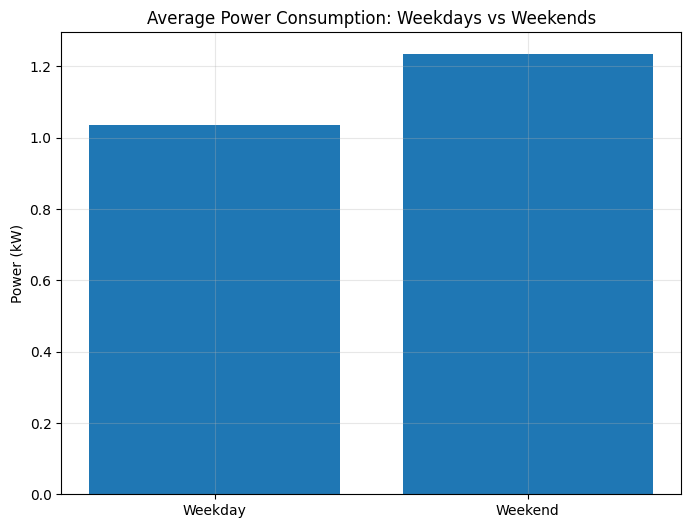

<Figure size 1000x600 with 0 Axes>

   Execution time: 0.30s
  Pandas Result:
    Weekday: 1.0354720516747509
    Weekend: 1.234232176791304

⚡ Executing Query 4: Find days where energy consumption exceeded 50 kWh.


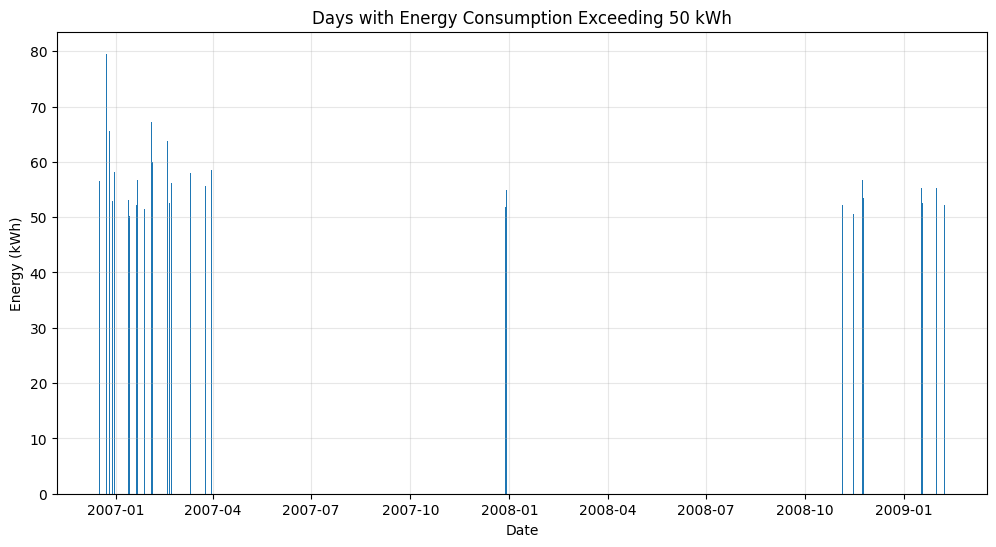

<Figure size 1000x600 with 0 Axes>

   Execution time: 0.36s
  Pandas Result:
    2006-12-17
    2006-12-23
    2006-12-26
    2006-12-29
    2006-12-31

⚡ Executing Query 5: Plot the energy usage trend for the first week of January 2007.


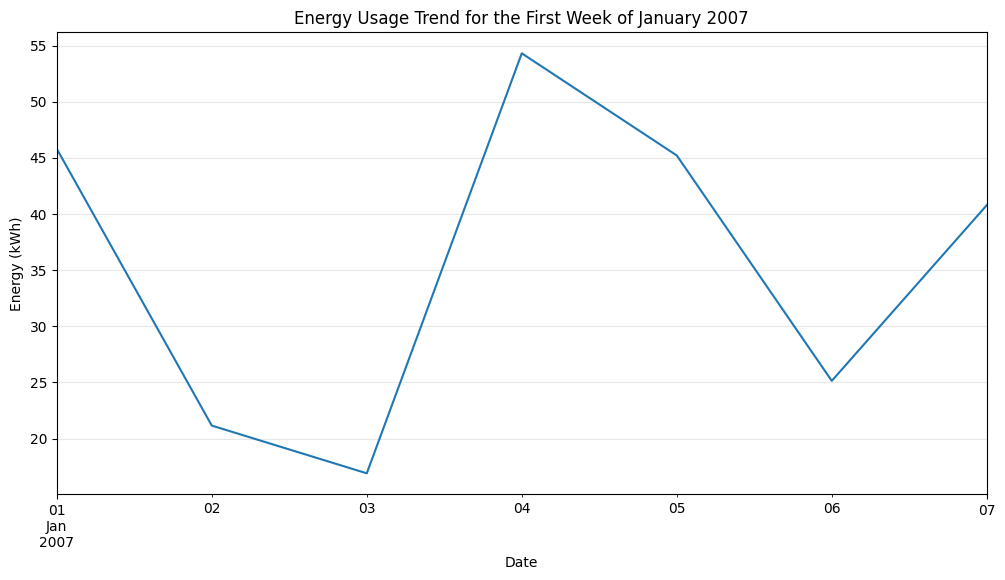

<Figure size 1000x600 with 0 Axes>

   Execution time: 0.25s
  Pandas Result:
    2007-01-01 00:00:00: 45.81673333333333
    2007-01-02 00:00:00: 21.153933333333335
    2007-01-03 00:00:00: 16.9009
    2007-01-04 00:00:00: 54.32353333333333
    2007-01-05 00:00:00: 45.22273333333333

⚡ Executing Query 6: Find the average voltage for each day of the first week of February 2007.


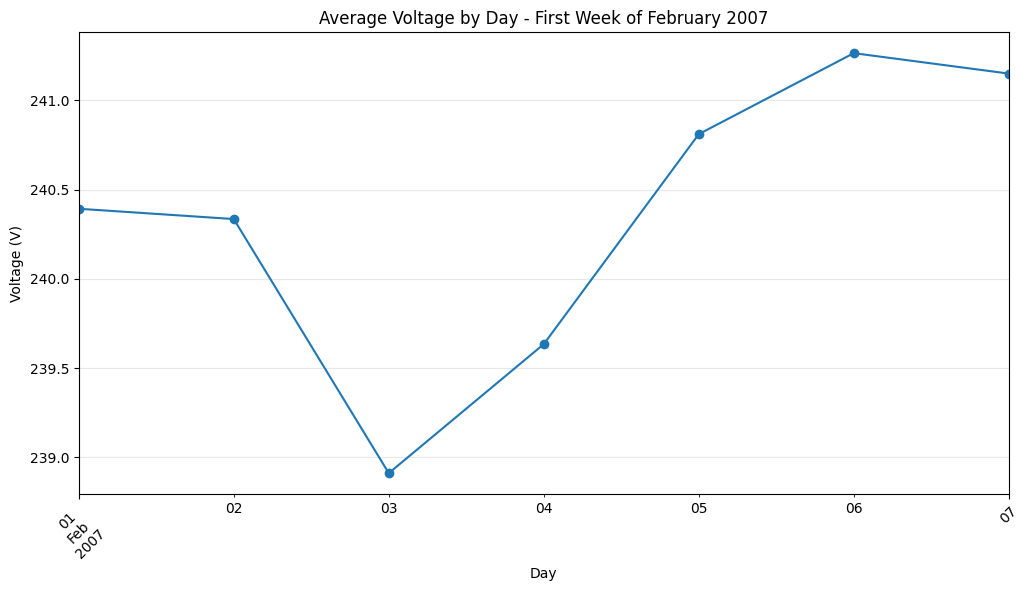

   Execution time: 0.25s
  Pandas Result:
    2007-02-01 00:00:00: 240.3921388888889
    2007-02-02 00:00:00: 240.3343888888889
    2007-02-03 00:00:00: 238.91019444444444
    2007-02-04 00:00:00: 239.63333333333333
    2007-02-05 00:00:00: 240.81031249999998

⚡ Executing Query 7: What is the correlation between global active power and sub-metering values?


<Figure size 1000x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


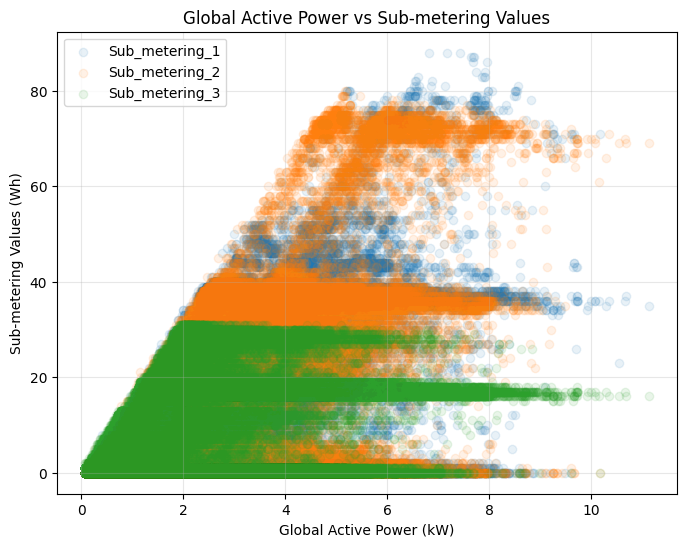

   Execution time: 48.88s
  Pandas Result:
    No 'result' variable found...

Results saved to query_results.csv

Execution summary: 7/7 queries succeeded


In [12]:
main()